In [3]:
import zipfile
with zipfile.ZipFile('/content/FruitinAmazon.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [5]:
train_dir = '/content/extracted_folder/FruitinAmazon/train'
test_dir = '/content/extracted_folder/FruitinAmazon/test'

In [6]:
# Get list of class directories
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

# Select one random image from each class
random_images = []
class_names = []

for class_name in class_dirs:
    class_path = os.path.join(train_dir, class_name)
    image_name = random.choice(os.listdir(class_path))  # Randomly select one image
    random_images.append(os.path.join(class_path, image_name))
    class_names.append(class_name)

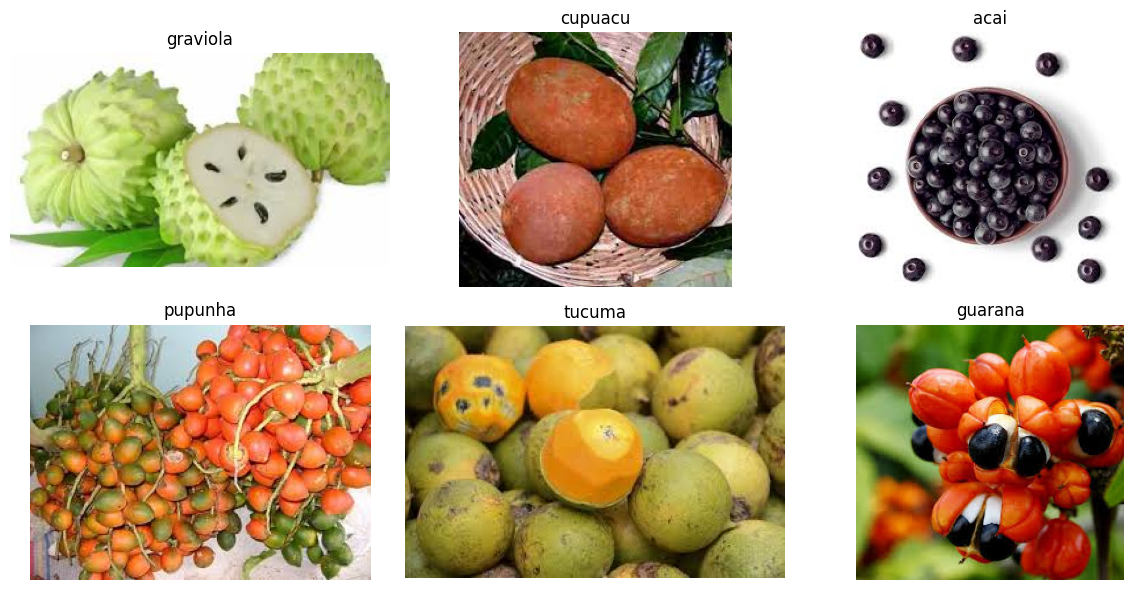

In [7]:
# Display images in a grid (2 rows)
plt.figure(figsize=(12, 6))
columns = (len(random_images) + 1) // 2
for i, img_path in enumerate(random_images):
    plt.subplot(2, columns, i + 1)
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(class_names[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
# List to store corrupted image paths
corrupted_images = []

# Iterate through class directories
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            try:
                with Image.open(image_path) as img:
                    img.verify()  # Verify the image integrity
            except (IOError, SyntaxError):
                corrupted_images.append(image_path)
                os.remove(image_path)
                print(f"Removed corrupted image: {image_path}")



# Final report
if corrupted_images:
    print(f"Total corrupted images removed: {len(corrupted_images)}")
else:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


In [9]:
# Desired image height and width
img_height = 128
img_width = 128
img_shape = (img_height, img_width,3)
batch_size = 32   # Number of images per batch
validation_split = 0.2  # 20% data for validation

# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255)  # Normalize pixel values to [0, 1]


In [10]:
# Load the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',         # Automatically infer the labels from subdirectories
    label_mode='int',          # Labels as integers (could also use 'categorical' or 'binary')
    image_size=(img_height, img_width),  # Resize images to this shape
    interpolation='nearest',   # Interpolation method for resizing
    batch_size=batch_size,     # Batch size for training
    shuffle=True,              # Shuffle the data
    validation_split=validation_split,  # Split data for training and validation
    subset='training',         # Specify this is for training subset
    seed=123                   # Random seed for reproducibility
)

# Apply the normalization (Rescaling) to the training dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.


In [11]:
# Load the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',         # Automatically infer the labels from subdirectories
    label_mode='int',          # Labels as integers
    image_size=(img_height, img_width),  # Resize images
    interpolation='nearest',   # Interpolation method for resizing
    batch_size=batch_size,     # Batch size for validation
    shuffle=True,              # Shuffle the validation data
    validation_split=validation_split,  # Same validation split for validation
    subset='validation',       # Specify this is for validation subset
    seed=123                   # Random seed for reproducibility
)

# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))



Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [12]:

# Define the model
modelcnn = keras.Sequential([
    # First Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=img_shape),  # (3, 3) filter, 32 filters input_layer= 128x128 for 3 layers:R,G,B
    layers.MaxPooling2D((2, 2), strides=2),  # Max pooling with (2, 2) filter, stride 2

    # Second Convolutional Layer
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # (3, 3) filter, 32 filters
    layers.MaxPooling2D((2, 2), strides=2),  # Max pooling with (2, 2) filter, stride 2

    # Flatten the output to feed into dense layers
    layers.Flatten(),

    # Fully connected hidden layers
    layers.Dense(64, activation='relu'),  # Hidden layer with 64 neurons
    layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons

    # Output layer with the number of classes
    layers.Dense(6, activation='softmax')  # 6 classes for fruit types
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
modelcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     2,097,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Compile the model
modelcnn.compile(
    optimizer='adam',  # Optimizer: Adam
    loss='sparse_categorical_crossentropy',  # Loss function for multi-class classification with integer labels
    metrics=['accuracy']  # Evaluation metric: Accuracy
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [16]:
# Define the callbacks
callbacks = [
    # Save the best model based on validation accuracy
    ModelCheckpoint(
        'best_model.h5',  # Path to save the best model
        save_best_only=True,  # Save only the best model
        monitor='val_loss',  # Monitor validation loss
        mode='min',  # Minimize the validation loss
        verbose=1
    ),
    # Stop training if validation loss doesn't improve for 10 epochs
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss
        patience=10,  # Wait for 10 epochs before stopping
        restore_best_weights=True,  # Restore best weights after stopping
        verbose=1
    )
]

In [17]:
# Train the model
history = modelcnn.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=16,  # Batch size
    callbacks=callbacks  # Callbacks for early stopping and saving the best model
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.1453 - loss: 2.0682
Epoch 1: val_loss improved from inf to 1.82140, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 597ms/step - accuracy: 0.1437 - loss: 2.1008 - val_accuracy: 0.2222 - val_loss: 1.8214
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.1944 - loss: 1.7729
Epoch 2: val_loss did not improve from 1.82140
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 432ms/step - accuracy: 0.1979 - loss: 1.7756 - val_accuracy: 0.1667 - val_loss: 1.9242
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3495 - loss: 1.6739
Epoch 3: val_loss did not improve from 1.82140
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step - accuracy: 0.3524 - loss: 1.6637 - val_accuracy: 0.1111 - val_loss: 2.0435
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 0.2737 - loss: 1.6014
Epoch 4: val_loss did not improve from 1.82140
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.2817 - loss: 1.5916 - val_accuracy: 0.2222 - val_loss: 1.8870
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.4149 - loss: 1.3960
Epoch 5: val_loss improved from 1.82140 to 1.75197, saving 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 669ms/step - accuracy: 0.4154 - loss: 1.3950 - val_accuracy: 0.2778 - val_loss: 1.7520
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.5405 - loss: 1.2210
Epoch 6: val_loss did not improve from 1.75197
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 571ms/step - accuracy: 0.5373 - loss: 1.2201 - val_accuracy: 0.1667 - val_loss: 1.8566
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.7338 - loss: 0.9538
Epoch 7: val_loss did not improve from 1.75197
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/step - accuracy: 0.7413 - loss: 0.9540 - val_accuracy: 0.2222 - val_loss: 1.7681
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7934 - loss: 0.7713
Epoch 8: val_loss did not improve from 1.75197
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 438ms/step - accuracy: 0.8034 - loss: 0.7625 - val_accuracy: 0.2778 - val_loss: 1.9929
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8970 - loss: 0.5294
Epoch 9: val_loss improved from 1.75197 to 1.72491, saving 

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 477ms/step - accuracy: 0.8845 - loss: 0.5367 - val_accuracy: 0.2222 - val_loss: 1.7249
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.9502 - loss: 0.4161
Epoch 10: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 427ms/step - accuracy: 0.9488 - loss: 0.4153 - val_accuracy: 0.2222 - val_loss: 1.8468
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9902 - loss: 0.2827
Epoch 11: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.9891 - loss: 0.2787 - val_accuracy: 0.2778 - val_loss: 2.4490
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step - accuracy: 1.0000 - loss: 0.2056
Epoch 12: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 429ms/step - accuracy: 1.0000 - loss: 0.2019 - val_accuracy: 0.3889 - val_loss: 2.0436
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 1.0000 - loss: 0.0905
Epoch 13: val_loss did not improve from 1.72491
3/3 

In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    seed=28             # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

Found 30 files belonging to 6 classes.


In [19]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = modelcnn.evaluate(test_ds)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4000 - loss: 1.3121
Test Loss: 1.3121, Test Accuracy: 0.4000


In [20]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

<Figure size 1200x1200 with 0 Axes>

<Figure size 1200x1200 with 0 Axes>

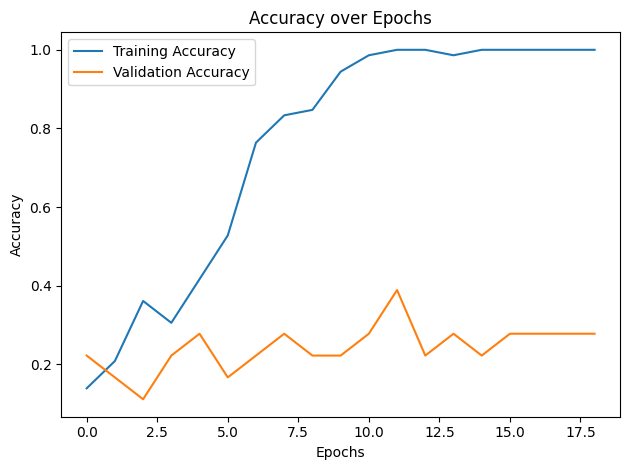

In [21]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

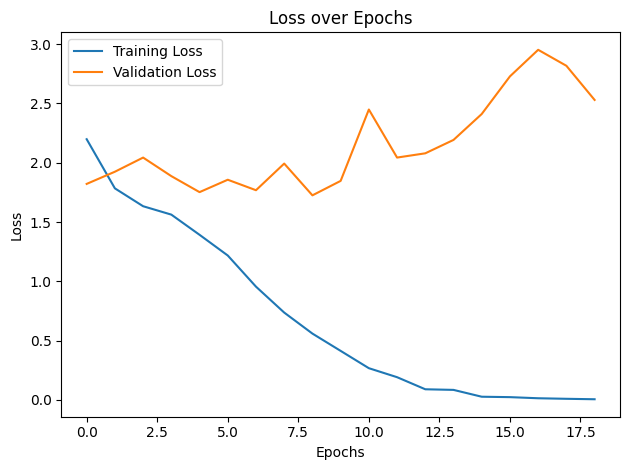

In [22]:
# Loss plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]

def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

In [24]:
# Define an improved CNN model with Batch Normalization and Dropout
modelcnn2 = keras.Sequential([

    # Data augmentation applied using Lambda layer
    layers.Lambda(data_augmentation, input_shape=img_shape),

    # Rescaling layer to normalize pixel values
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(6, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model
modelcnn2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [26]:
# Display model summary
modelcnn2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,485,574 (32.37 MB)

 Trainable params: 8,484,614 (32.37 MB)

 Non-trainable params: 960 (3.75 KB)

In [27]:
# Train the model
cnn_history = modelcnn2.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=250,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=callbacks  # Callbacks for early stopping and saving the best model
    # jit_compile =False # Remove this line - it's not a valid argument for model.fit
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.1939 - loss: 2.7784
Epoch 1: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.2010 - loss: 2.7560 - val_accuracy: 0.1111 - val_loss: 1.8016
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4595 - loss: 1.7297
Epoch 2: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.4627 - loss: 1.7239 - val_accuracy: 0.1111 - val_loss: 1.8483
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6586 - loss: 0.8893
Epoch 3: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6675 - loss: 0.8764 - val_accuracy: 0.1111 - val_loss: 1.9062
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6400 - loss: 0.9221
Epoch 4: val_loss did not improve from 1.72491
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.6398 - loss: 0.9280 - val_accuracy: 0.1111 - val_loss: 1.9570
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━

In [28]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelcnn2.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.1667 - loss: 1.7943


Test Loss: 1.7943, Test Accuracy: 0.1667


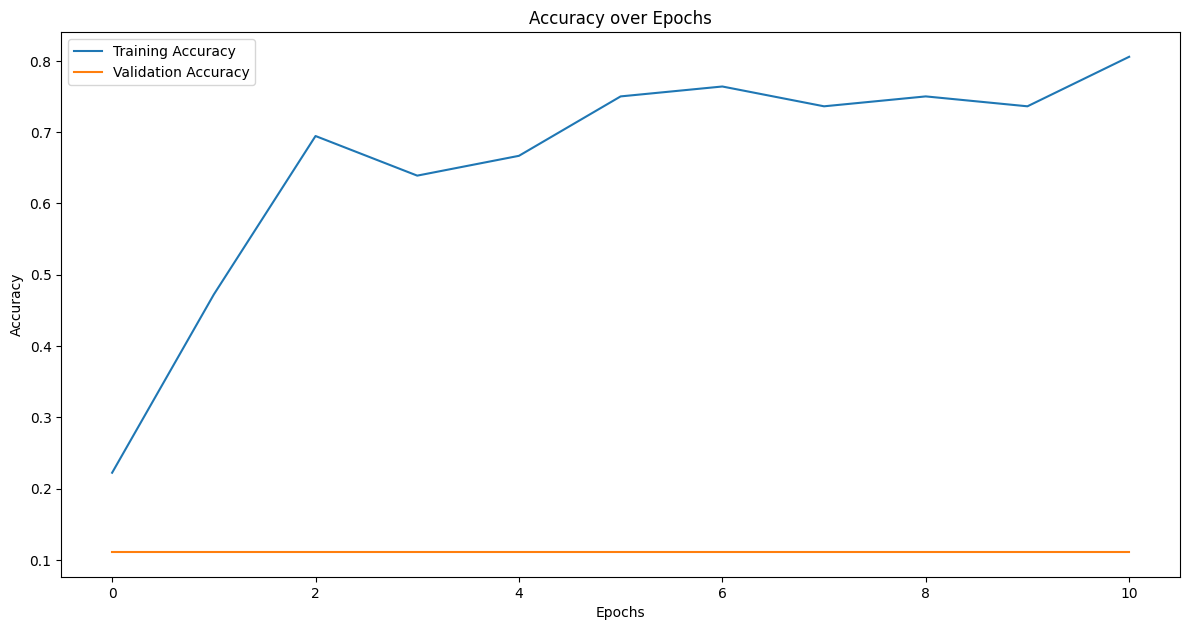

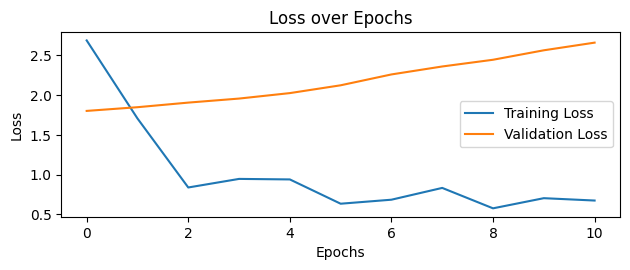

In [29]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input

# Define input shape
input_shape = (128, 128, 3)
base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add custom layers on top
inputs = Input(shape=input_shape)
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)  # Adjust to your number of classes

# Create the model
modelnetv2 = Model(inputs, outputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [31]:
from tensorflow.keras.optimizers import Adam

modelnetv2.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
vnet2_history = modelnetv2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.1244 - loss: 2.6263
Epoch 1: val_loss improved from 1.72491 to 1.56704, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.1280 - loss: 2.6131 - val_accuracy: 0.3889 - val_loss: 1.5670
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.4491 - loss: 1.2513
Epoch 2: val_loss improved from 1.56704 to 1.31626, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step - accuracy: 0.4549 - loss: 1.2464 - val_accuracy: 0.5556 - val_loss: 1.3163
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.6881 - loss: 0.7345
Epoch 3: val_loss improved from 1.31626 to 0.92207, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step - accuracy: 0.7001 - loss: 0.7170 - val_accuracy: 0.6667 - val_loss: 0.9221
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.8953 - loss: 0.3474
Epoch 4: val_loss improved from 0.92207 to 0.69813, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step - accuracy: 0.8937 - loss: 0.3465 - val_accuracy: 0.7778 - val_loss: 0.6981
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.9751 - loss: 0.1734
Epoch 5: val_loss improved from 0.69813 to 0.65680, saving model to best_model.h5


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 785ms/step - accuracy: 0.9744 - loss: 0.1743 - val_accuracy: 0.7222 - val_loss: 0.6568
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.9797 - loss: 0.1172
Epoch 6: val_loss did not improve from 0.65680
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.9813 - loss: 0.1144 - val_accuracy: 0.7222 - val_loss: 0.6891
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 1.0000 - loss: 0.0591
Epoch 7: val_loss did not improve from 0.65680
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - accuracy: 1.0000 - loss: 0.0583 - val_accuracy: 0.7222 - val_loss: 0.7398
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accuracy: 1.0000 - loss: 0.0271
Epoch 8: val_loss did not improve from 0.65680
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 1.0000 - loss: 0.0274 - val_accuracy: 0.7222 - val_loss: 0.7993
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 1.0000 - loss: 0.0239
Epoch 9: val_loss did not improve from 0.65680
3/3 ━━━━━━━━

In [33]:
modelnetv2.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,752,212 (10.50 MB)

 Trainable params: 164,742 (643.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 329,486 (1.26 MB)

In [34]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    interpolation='nearest',
    batch_size=batch_size,
    shuffle=False,              # No shuffling for consistent evaluation
)

# Apply the same normalization as train/val
test_ds = test_ds.map(lambda x, y: (rescale(x), y))

# Evaluate the model on the test dataset
test_loss, test_accuracy = modelnetv2.evaluate(test_ds)
print(f"\n\nTest Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step - accuracy: 0.8333 - loss: 0.5101


Test Loss: 0.5101, Test Accuracy: 0.8333


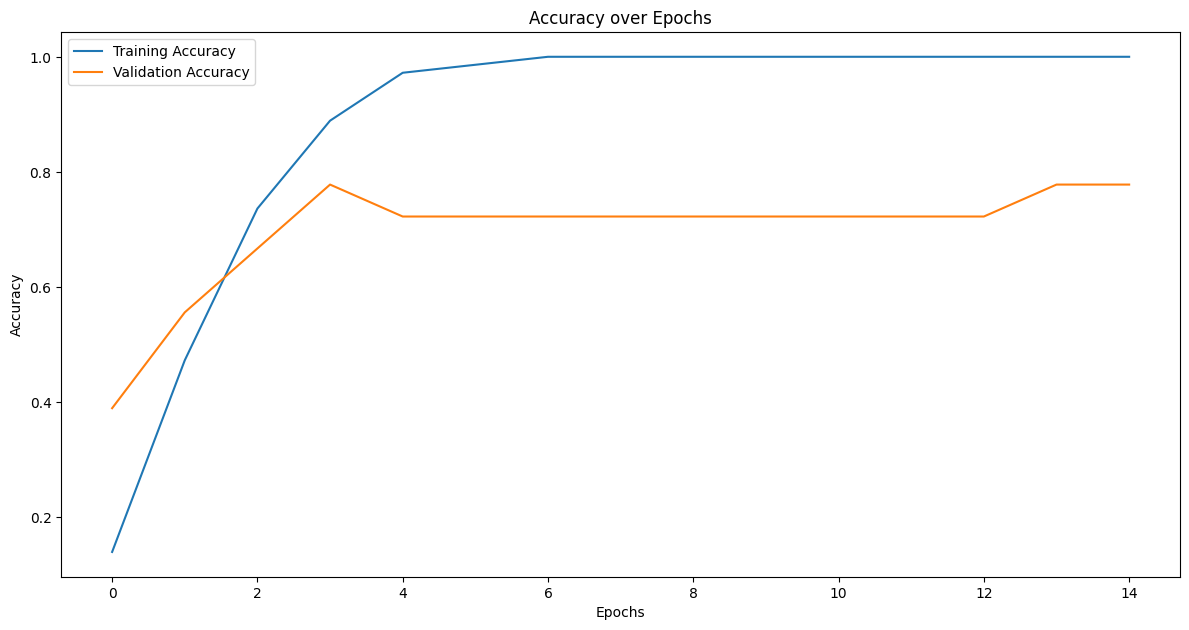

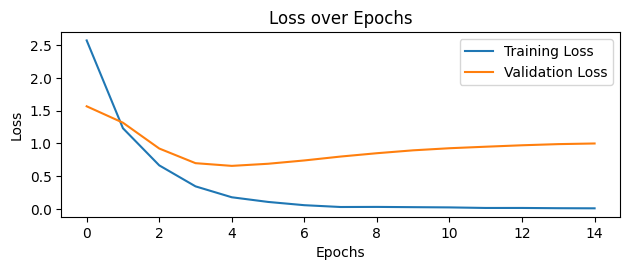

In [35]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 12))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(vnet2_history.history['accuracy'], label='Training Accuracy')
plt.plot(vnet2_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(vnet2_history.history['loss'], label='Training Loss')
plt.plot(vnet2_history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()